In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/PFE

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from dummy import *
from GCN_model import *
from GIN_model import *

In [2]:
dtype = torch.long
n_train = 32768
n_valid = 4096 
batch_size = 128
learning_rate = 0.0001
num_epochs = 50
n_nodes = 10
n_features = 3
hidden_dim = 10
n_classes = 4
dropout = 0.5                        

train_dataset, valid_dataset, train_features, valid_features = get_dataset(n_train, n_valid,
                                                                           n_nodes, n_classes, n_features)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

X = torch.ones([batch_size, n_nodes, n_features])

model = TwoLayerGCN(n_features, hidden_dim, n_classes, dropout)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_log = torch.zeros((num_epochs, 4), dtype=torch.float, requires_grad=False)

In [3]:
correct = 0
total = 0
for epoch in range(num_epochs):
    for i, (A, labels) in enumerate(train_loader):
        
        # Forward pass
        outputs = model(X, A)
        loss = criterion(outputs.transpose(1,2), labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs,2)
        correct += (predicted == labels).sum()
        total += labels.numel()
        
    train_log[epoch, 0] = epoch
    train_log[epoch, 1] = loss.item()
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss))
    train_log[epoch, 2] = (100* correct / total)
    
    
with torch.no_grad():
    correct = 0
    total = 0
    for A, labels in valid_loader:
        outputs = model(X, A)
        _, predicted = torch.max(outputs, 2)
        total += labels.numel()
        correct += (predicted == labels).sum()

    print('Accuracy of the network on the test data: {} %'.format(100 * correct / total))
    
train_log = train_log.detach().numpy()

Epoch [1/50], Loss: 1.6036
Epoch [2/50], Loss: 1.4021
Epoch [3/50], Loss: 1.2563
Epoch [4/50], Loss: 1.0957
Epoch [5/50], Loss: 0.9511
Epoch [6/50], Loss: 0.7785
Epoch [7/50], Loss: 0.6593
Epoch [8/50], Loss: 0.5404
Epoch [9/50], Loss: 0.4602
Epoch [10/50], Loss: 0.3534
Epoch [11/50], Loss: 0.2856
Epoch [12/50], Loss: 0.2227
Epoch [13/50], Loss: 0.1908
Epoch [14/50], Loss: 0.1551
Epoch [15/50], Loss: 0.1323
Epoch [16/50], Loss: 0.1238
Epoch [17/50], Loss: 0.0858
Epoch [18/50], Loss: 0.0819
Epoch [19/50], Loss: 0.0672
Epoch [20/50], Loss: 0.0508
Epoch [21/50], Loss: 0.0407
Epoch [22/50], Loss: 0.0582
Epoch [23/50], Loss: 0.0392
Epoch [24/50], Loss: 0.0367
Epoch [25/50], Loss: 0.0403
Epoch [26/50], Loss: 0.0225
Epoch [27/50], Loss: 0.0316
Epoch [28/50], Loss: 0.0275
Epoch [29/50], Loss: 0.0229
Epoch [30/50], Loss: 0.0329
Epoch [31/50], Loss: 0.0132
Epoch [32/50], Loss: 0.0277
Epoch [33/50], Loss: 0.0176
Epoch [34/50], Loss: 0.0274
Epoch [35/50], Loss: 0.0089
Epoch [36/50], Loss: 0.0156
E

[Text(63.125, 0.5, 'train_acc'), Text(0.5, 69.00000000000009, 'epochs')]

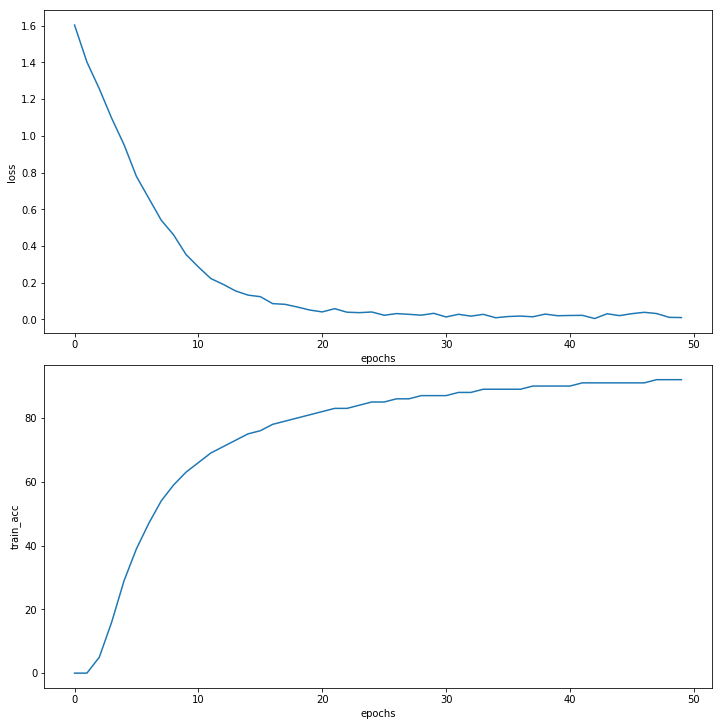

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
fig.tight_layout()

ax[0].plot(train_log[:,0], train_log[:,1])
ax[0].set(xlabel="epochs", ylabel="loss")

ax[1].plot(train_log[:,0], train_log[:,2])
ax[1].set(xlabel="epochs", ylabel="train_acc")

In [5]:
batch_size = 128
learning_rate = 0.001
num_epochs = 50
hidden_dim = 50
dropout = 0.1                        
n_gnn_layers = 2
n_mlp_layers = 2
learn_eps = True

model = GIN(n_gnn_layers, n_mlp_layers, n_features, hidden_dim, n_classes, learn_eps, dropout)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_log = torch.zeros((num_epochs, 4), dtype=torch.float, requires_grad=False)

correct = 0
total = 0
for epoch in range(num_epochs):
    for i, (A, labels) in enumerate(train_loader):
        
        # Forward pass
        _, outputs = model(A, X) # outputs = node scores, just like in GCN
        # TO DO: find a way to iterate over train_features_loader to pick batches of features for training 
        loss = criterion(outputs.transpose(1, 2), labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs,2)
        correct += (predicted == labels).sum()
        total += labels.numel()
        
    train_log[epoch, 0] = epoch
    train_log[epoch, 1] = loss.item()
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss))
    train_log[epoch, 2] = (100* correct / total)
    
    
with torch.no_grad():
    correct = 0
    total = 0
    for A, labels in valid_loader:
        _, outputs = model(A, X)
        #outputs = outputs.transpose(1, 2)
        _, predicted = torch.max(outputs, 2)
        total += labels.numel()
        correct += (predicted == labels).sum()

    print('Accuracy of the network on the test data: {} %'.format(100 * correct / total))
    
train_log = train_log.detach().numpy()

Epoch [1/50], Loss: 0.0384
Epoch [2/50], Loss: 0.0230
Epoch [3/50], Loss: 0.0290
Epoch [4/50], Loss: 0.0222
Epoch [5/50], Loss: 0.0215
Epoch [6/50], Loss: 0.0257
Epoch [7/50], Loss: 0.0179
Epoch [8/50], Loss: 0.0191
Epoch [9/50], Loss: 0.0181
Epoch [10/50], Loss: 0.0206
Epoch [11/50], Loss: 0.0193
Epoch [12/50], Loss: 0.0201
Epoch [13/50], Loss: 0.0196
Epoch [14/50], Loss: 0.0208
Epoch [15/50], Loss: 0.0218
Epoch [16/50], Loss: 0.0196
Epoch [17/50], Loss: 0.0285
Epoch [18/50], Loss: 0.0215
Epoch [19/50], Loss: 0.0225
Epoch [20/50], Loss: 0.0232
Epoch [21/50], Loss: 0.0240
Epoch [22/50], Loss: 0.0196
Epoch [23/50], Loss: 0.0203
Epoch [24/50], Loss: 0.0151
Epoch [25/50], Loss: 0.0207
Epoch [26/50], Loss: 0.0203
Epoch [27/50], Loss: 0.0222
Epoch [28/50], Loss: 0.0209
Epoch [29/50], Loss: 0.0195
Epoch [30/50], Loss: 0.0170
Epoch [31/50], Loss: 0.0181
Epoch [32/50], Loss: 0.0205
Epoch [33/50], Loss: 0.0177
Epoch [34/50], Loss: 0.0205
Epoch [35/50], Loss: 0.0151
Epoch [36/50], Loss: 0.0215
E

[Text(63.125, 0.5, 'train_acc'), Text(0.5, 69.00000000000009, 'epochs')]

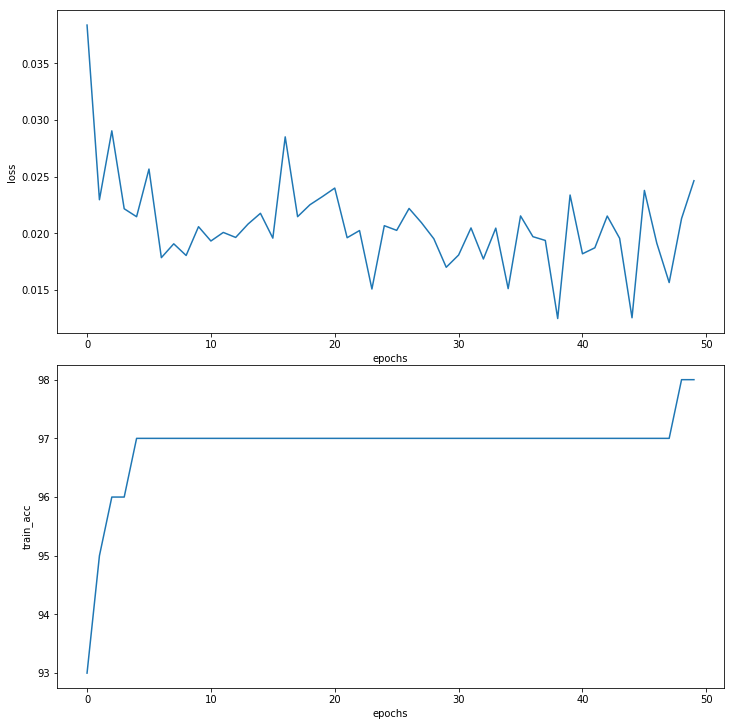

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
fig.tight_layout()

ax[0].plot(train_log[:,0], train_log[:,1])
ax[0].set(xlabel="epochs", ylabel="loss")

ax[1].plot(train_log[:,0], train_log[:,2])
ax[1].set(xlabel="epochs", ylabel="train_acc")

In [7]:
model = GIN(n_gnn_layers, n_mlp_layers, n_features, hidden_dim, n_classes, learn_eps, dropout, attention=True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_log = torch.zeros((num_epochs, 4), dtype=torch.float, requires_grad=False)

correct = 0
total = 0
for epoch in range(num_epochs):
    for i, (A, labels) in enumerate(train_loader):
        
        # Forward pass
        _, outputs = model(A, X) # outputs = node scores, just like in GCN
        # TO DO: find a way to iterate over train_features_loader to pick batches of features for training 
        loss = criterion(outputs.transpose(1, 2), labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs,2)
        correct += (predicted == labels).sum()
        total += labels.numel()
        
    train_log[epoch, 0] = epoch
    train_log[epoch, 1] = loss.item()
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss))
    train_log[epoch, 2] = (100* correct / total)
    
    
with torch.no_grad():
    correct = 0
    total = 0
    for A, labels in valid_loader:
        _, outputs = model(A, X)
        #outputs = outputs.transpose(1, 2)
        _, predicted = torch.max(outputs, 2)
        total += labels.numel()
        correct += (predicted == labels).sum()

    print('Accuracy of the network on the test data: {} %'.format(100 * correct / total))
    
train_log = train_log.detach().numpy()

/home/waretf/PFE/layers.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = F.softmax(scores).flatten()


Epoch [1/50], Loss: 0.0343
Epoch [2/50], Loss: 0.0240
Epoch [3/50], Loss: 0.0256
Epoch [4/50], Loss: 0.0253
Epoch [5/50], Loss: 0.0297
Epoch [6/50], Loss: 0.0250
Epoch [7/50], Loss: 0.0225
Epoch [8/50], Loss: 0.0257
Epoch [9/50], Loss: 0.0242
Epoch [10/50], Loss: 0.0199
Epoch [11/50], Loss: 0.0263
Epoch [12/50], Loss: 0.0302
Epoch [13/50], Loss: 0.0252
Epoch [14/50], Loss: 0.0193
Epoch [15/50], Loss: 0.0271
Epoch [16/50], Loss: 0.0309
Epoch [17/50], Loss: 0.0241
Epoch [18/50], Loss: 0.0191
Epoch [19/50], Loss: 0.0291
Epoch [20/50], Loss: 0.0178
Epoch [21/50], Loss: 0.0193
Epoch [22/50], Loss: 0.0225
Epoch [23/50], Loss: 0.0188
Epoch [24/50], Loss: 0.0152
Epoch [25/50], Loss: 0.0207
Epoch [26/50], Loss: 0.0401
Epoch [27/50], Loss: 0.0192
Epoch [28/50], Loss: 0.0252
Epoch [29/50], Loss: 0.0219
Epoch [30/50], Loss: 0.0225
Epoch [31/50], Loss: 0.0216
Epoch [32/50], Loss: 0.0190
Epoch [33/50], Loss: 0.0289
Epoch [34/50], Loss: 0.0194
Epoch [35/50], Loss: 0.0194
Epoch [36/50], Loss: 0.0201
E

[Text(63.125, 0.5, 'train_acc'), Text(0.5, 69.00000000000009, 'epochs')]

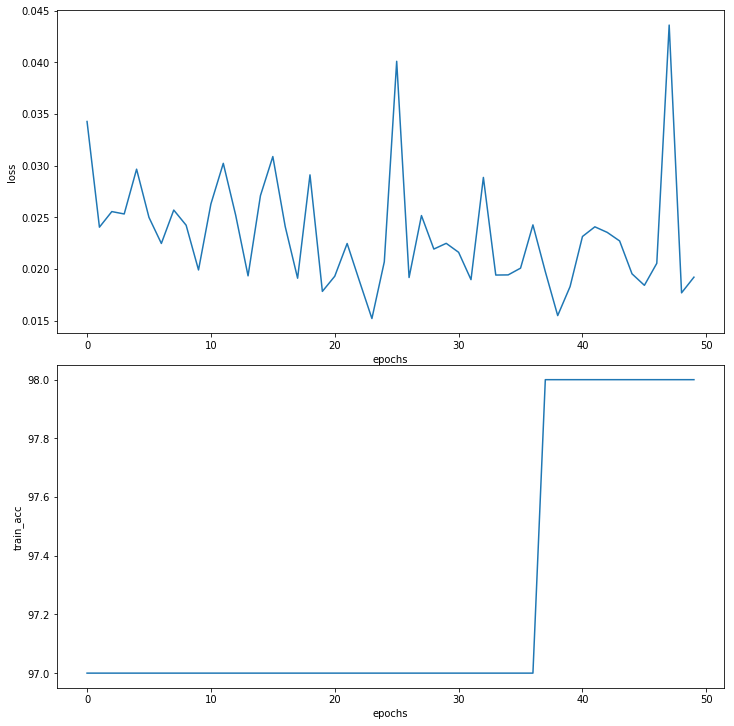

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
fig.tight_layout()

ax[0].plot(train_log[:,0], train_log[:,1])
ax[0].set(xlabel="epochs", ylabel="loss")

ax[1].plot(train_log[:,0], train_log[:,2])
ax[1].set(xlabel="epochs", ylabel="train_acc")